In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
%pwd

/home/markus/Documents/regression-prediction


'/home/markus/Documents/regression-prediction'

In [3]:
from experiments.modeleval_utils import *

/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [7]:
def print_classification_report_at_threshold(clf, X, y, threshold):
    y_score = get_y_score(clf, X)
    y_pred = y_score >= threshold
    print(f'{threshold=}')
    report = metrics.classification_report(y, y_pred, digits=4)
    print(report)
    roc_auc = metrics.roc_auc_score(y, y_score)
    average_precision = metrics.average_precision_score(y, y_score)
    print(f'{roc_auc=} {average_precision=}')

In [11]:
def fit_best_model(output_dir, model, data, feature_type, target, scoring, X_train, y_train):
    pipeline, best_params, best_result = get_pipeline(output_dir, data, feature_type, target, scoring, model)
    pipeline.fit(X_train, y_train)
    return pipeline

In [9]:
import shap
def plot_important_features(clf, X, feature_names, max_display=10):
    explainer = shap.Explainer(clf, X, feature_names=feature_names)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, max_display=max_display, feature_names=feature_names)
    plt.show()

In [7]:
data = 'bugbug_buglevel'
scoring = 'average_precision'

In [8]:
feature_type = 'traditional' # traditional, bow

In [16]:
model = 'lr'
target = 'performance'

X, y, features = data_map[feature_type][data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

perf_pipeline = fit_best_model(model, data, feature_type, target, scoring, X_train, y_train)

performance: 1880 positive 2.77% - negative 66041 97.23%
X.shape=(67921, 302)



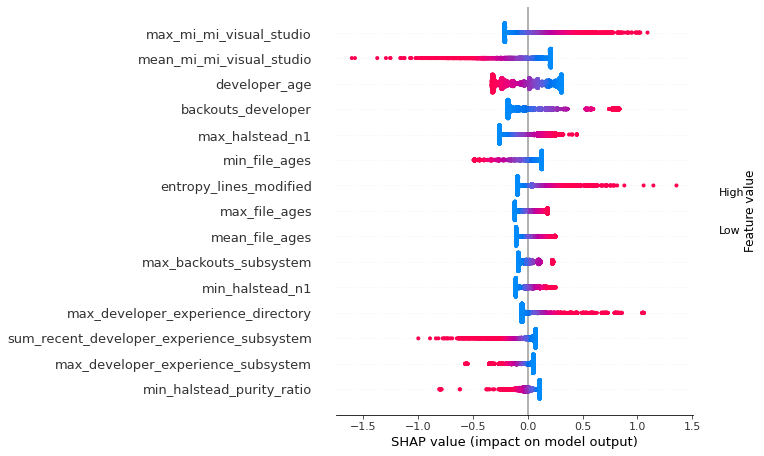

In [17]:
perf_model = perf_pipeline['model']

if feature_type == 'traditional':
    X_ = perf_pipeline['scaler'].transform(X_test)
    feature_names = features.columns
    # plot_important_features(perf_model, X_, features.columns, max_display=15)
else:
    X_ = X_test.toarray()
    feature_names = features
    # plot_important_features(perf_model, X_, features, max_display=15)

explainer = shap.Explainer(perf_model, X_, feature_names=feature_names)

shap_values = explainer.shap_values(X_)
shap.summary_plot(shap_values, X_, max_display=15, feature_names=feature_names)

# shap_values = explainer(X_)
#shap.beeswarm_plot(shap_values, max_display=15)

In [30]:
bug_x = X[bug_ix, :].reshape(1, -1)
bug_x = perf_pipeline['scaler'].transform(bug_x)

In [34]:
perf_model.predict_proba(bug_x)

array([[0.46548734, 0.53451266]])

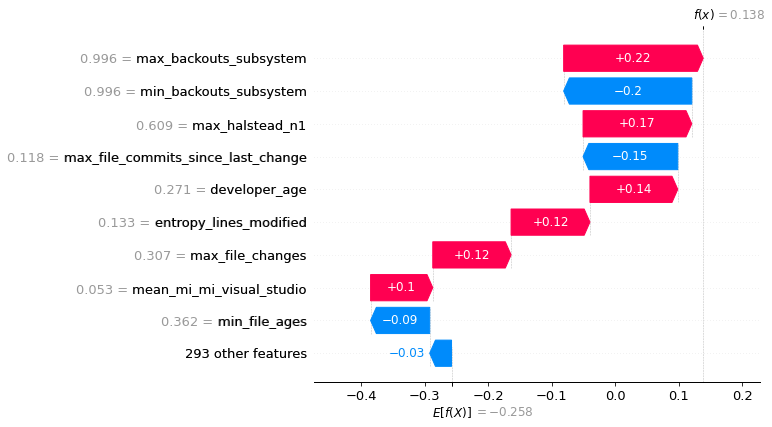

In [32]:
explainer = shap.Explainer(perf_model, X_, feature_names=feature_names)
shap_values = explainer(bug_x)
shap.waterfall_plot(shap_values[0])


In [20]:
# db7fd455cc6af66a965d3ee6f4b3c3a2d00f1a37
# ix = 87809
bug_ix = 59972

In [ ]:
type(shap_values)

In [ ]:
plot_precision_recall_curve_with_f1(perf_pipeline, X_test, y_test)
t, f1 = get_best_f1_threshold(perf_pipeline, X_train, y_train)
print_classification_report_at_threshold(perf_pipeline, X_test, y_test, t)

In [ ]:
target = 'regression'

X, y, features = data_map[feature_type][data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

reg_pipeline = fit_best_model(model, data, feature_type, target, scoring, X_train, y_train)

In [ ]:
reg_model = reg_pipeline['model']

if feature_type == 'traditional':
    X_ = perf_pipeline['scaler'].transform(X_test)
    plot_important_features(perf_model, X_, features.columns, max_display=15)
else:
    X_ = X_test.toarray()
    plot_important_features(perf_model, X_, features, max_display=15)

In [ ]:
plot_precision_recall_curve_with_f1(reg_pipeline, X_test, y_test)
t, f1 = get_best_f1_threshold(reg_pipeline, X_train, y_train)
print_classification_report_at_threshold(reg_pipeline, X_test, y_test, t)

### Predict Performance on Regression Model

In [5]:
data = 'bugbug_buglevel'
scoring = 'average_precision'

In [5]:
feature_type = 'traditional' # traditional, bow

In [ ]:
model = 'xgb' # best regression model
target = 'regression'

X, y, features = data_map[feature_type][data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

reg_pipeline = fit_best_model(model, data, feature_type, target, scoring, X_train, y_train)

In [ ]:
X_perf, y_perf, features = data_map[feature_type][data]('performance')
X_perf_train, X_perf_test, y_perf_train, y_perf_test = train_test_split(X_perf, y_perf, test_size=0.1, shuffle=False)

perf_model = 'lr' # best performance model
perf_pipeline = fit_best_model(perf_model, data, feature_type, 'performance', scoring, X_perf_train, y_perf_train)

In [ ]:
# regression model evaluated on performance regressions
_ = plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring,
    [('Trained on performance regressions', perf_pipeline), ('Trained on all reggressions', reg_pipeline)],
    X_train, X_perf_test, y_train, y_perf_test, save=False, figsize=(6,4), ylim=[0,1.])

In [ ]:
# regression model evaluated on all regressions
_ = plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring,
    [('Trained on performance regressions', perf_pipeline), ('Trained on all reggressions', reg_pipeline)],
    X_train, X_test, y_train, y_test, save=False, figsize=(6,4), ylim=[0,1.])

traditional
regression: 14287 positive 21.03% - negative 53634 78.97%
X.shape=(67921, 56)

performance: 1880 positive 2.77% - negative 66041 97.23%
X.shape=(67921, 56)



The max_iter was reached which means the coef_ did not converge
invalid value encountered in true_divide


Regression Model
threshold=0.28509794974675506
              precision    recall  f1-score   support

           0     0.8535    0.8076    0.8299      5375
           1     0.3943    0.4746    0.4307      1418

    accuracy                         0.7381      6793
   macro avg     0.6239    0.6411    0.6303      6793
weighted avg     0.7577    0.7381    0.7466      6793

roc_auc=0.7004141437333945 average_precision=0.4173164069234786
Performance Model
threshold=0.7347832588716675
              precision    recall  f1-score   support

           0     0.8070    0.9591    0.8765      5375
           1     0.4568    0.1305    0.2030      1418

    accuracy                         0.7861      6793
   macro avg     0.6319    0.5448    0.5397      6793
weighted avg     0.7339    0.7861    0.7359      6793

roc_auc=0.6382286220356217 average_precision=0.32620024664202674
bow
regression: 14287 positive 21.03% - negative 53634 78.97%
X.shape=(67921, 50000)

performance: 1880 positive 2.77% - ne

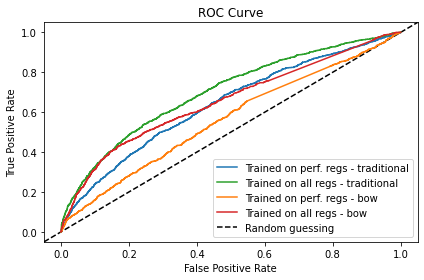

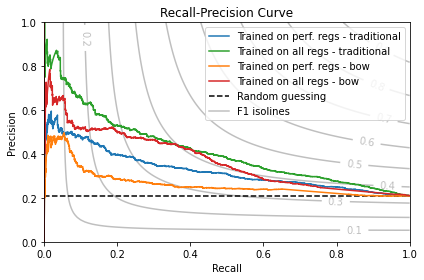

Regression Model
threshold=0.2735196
              precision    recall  f1-score   support

           0     0.8444    0.8500    0.8472      5375
           1     0.4168    0.4062    0.4114      1418

    accuracy                         0.7574      6793
   macro avg     0.6306    0.6281    0.6293      6793
weighted avg     0.7551    0.7574    0.7562      6793

roc_auc=0.6542938301571162 average_precision=0.36949034789518254
Performance Model
threshold=0.11372902631795351
              precision    recall  f1-score   support

           0     0.7983    0.9818    0.8806      5375
           1     0.4645    0.0599    0.1062      1418

    accuracy                         0.7893      6793
   macro avg     0.6314    0.5209    0.4934      6793
weighted avg     0.7286    0.7893    0.7189      6793

roc_auc=0.5625488896906878 average_precision=0.2628878438991827


In [17]:
data = 'bugbug_buglevel'
scoring = 'average_precision'
feature_type = 'traditional'
kind = 'perf_on_reg' #reg_on_perf, perf_on_reg
output_dir = 'experiments/results_FS'
drop_columns = True
print(feature_type)

X, y, features = data_map[feature_type][data]('regression', drop_columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

reg_model = 'rf'
reg_pipeline = fit_best_model(output_dir, reg_model, data, feature_type, 'regression', scoring, X_train, y_train)

X_perf, y_perf, features = data_map[feature_type][data]('performance', drop_columns)
X_perf_train, X_perf_test, y_perf_train, y_perf_test = train_test_split(X_perf, y_perf, test_size=0.1, shuffle=False)

perf_model = 'lr' # best performance model
perf_pipeline = fit_best_model(output_dir, perf_model, data, feature_type, 'performance', scoring, X_perf_train, y_perf_train)

if kind == 'reg_on_perf':
    y_ = y_perf_test
else: # perf_on_reg
    y_ = y_test

roc_fig, roc_ax, pr_fig, pr_ax = plot_roc_auc_rec_prec_for_all_models('', data, feature_type, scoring,
    [('Trained on perf. regs - traditional', perf_pipeline), ('Trained on all regs - traditional', reg_pipeline)],
    X_train, X_test, y_train, y_, save=False, show=False, figsize=(6,4), ylim=[0,1.],
    colors=['tab:blue','tab:green'], linestyles=['solid', 'solid'])


print('Regression Model')
reg_t, _ = get_best_f1_threshold(reg_pipeline, X_train, y_train)
print_classification_report_at_threshold(reg_pipeline, X_test, y_, reg_t)

print('Performance Model')
perf_t, _ = get_best_f1_threshold(perf_pipeline, X_perf_train, y_perf_train)
print_classification_report_at_threshold(perf_pipeline, X_test, y_, perf_t)




feature_type = 'bow'
print(feature_type)

X, y, features = data_map[feature_type][data]('regression')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

reg_model = 'xgb'
reg_pipeline = fit_best_model(output_dir, reg_model, data, feature_type, 'regression', scoring, X_train, y_train)

X_perf, y_perf, features = data_map[feature_type][data]('performance')
X_perf_train, X_perf_test, y_perf_train, y_perf_test = train_test_split(X_perf, y_perf, test_size=0.1, shuffle=False)

perf_model = 'lr' # best performance model
perf_pipeline = fit_best_model(output_dir, perf_model, data, feature_type, 'performance', scoring, X_perf_train, y_perf_train)

_ = plot_roc_auc_rec_prec_for_all_models('', data, feature_type, scoring,
    [('Trained on perf. regs - bow', perf_pipeline), ('Trained on all regs - bow', reg_pipeline)],
    X_train, X_test, y_train, y_, figsize=(6,4), ylim=[0,1.],
    colors=['tab:orange','tab:red'], linestyles=['solid', 'solid'],
    roc_fig=roc_fig, roc_ax=roc_ax, pr_fig=pr_fig, pr_ax=pr_ax,
    save=True, path=os.path.join(output_dir, f'plots_perf_vs_reg/{kind}'))

plt.show()


print('Regression Model')
reg_t, _ = get_best_f1_threshold(reg_pipeline, X_train, y_train)
print_classification_report_at_threshold(reg_pipeline, X_test, y_, reg_t)

print('Performance Model')
perf_t, _ = get_best_f1_threshold(perf_pipeline, X_perf_train, y_perf_train)
print_classification_report_at_threshold(perf_pipeline, X_test, y_, perf_t)


In [ ]:
vocabulary = {}
for i, f in enumerate(features):
    vocabulary[f] = i

In [ ]:
from src.labeling import *

In [ ]:
hg_to_git, git_to_hg = get_hg_git_mapping()

In [ ]:
fix_and_introducers = read_data_from_json(f'data/labeling/fixed_defect_szz/results/fix_and_introducers_pairs.json')
for pair in fix_and_introducers:
    pair[0] = git_to_hg[pair[0]]
    pair[1] = git_to_hg[pair[1]]

In [9]:
fix_commit = '9c9241d58d525eef5d9228763fd930f3adabc56e'
bug_commit = 'db7fd455cc6af66a965d3ee6f4b3c3a2d00f1a37' #  '97fb4c742d684da863aa27a32ae9d1daa8d67928'

In [ ]:
[(fix, introducer) for fix, introducer in fix_and_introducers if fix == fix_commit]

In [ ]:
fix_and_introducers_df = pd.DataFrame(fix_and_introducers, columns=['fix', 'introducer'])

In [ ]:
introducers = set(fix_and_introducers_df['introducer'])
bug_commit in introducers # check if true positive


In [10]:
F_buglevel = pd.read_csv('data/feature_extractor/features_buglevel.csv')
F_commitlevel = pd.read_csv('data/feature_extractor/features_commitlevel.csv')

In [11]:
rev_to_ix = {rev: i for i, rev in enumerate(F_commitlevel['revision'])}
first_rev_to_ix = {rev: i for i, rev in enumerate(F_buglevel['first_revision'])}

In [13]:
# ix = rev_to_ix[bug_commit]
ix = first_rev_to_ix[bug_commit]
ix

59972

In [14]:
rev_to_ix[bug_commit], first_rev_to_ix[bug_commit]

(87809, 59972)